In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def f(x):
    return 3*x**2 - 4*x + 5

To plot a charge, define the x values, and then calculate the y values from those x values

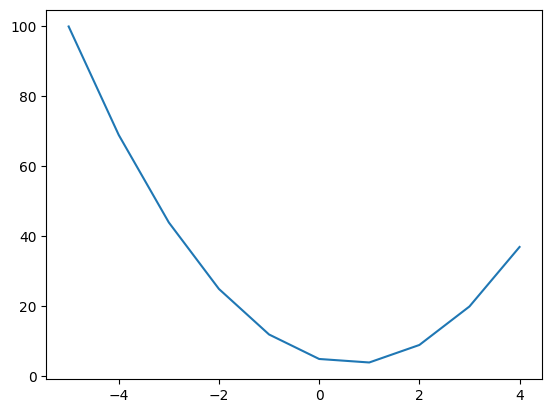

In [16]:
x = np.arange(-5, 5, 1)
y = f(x)
plt.plot(x, y)

To calculate deir

In [31]:
h = 0.000001
x = 3.0
print((f(x+h)- f(x))/h) # manual calculation 
6*x - 4 # the derivative

14.000003002223593


14.0

Now, multi-variable derivatives

In [37]:
h = 0.001 # the change

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
print(f'{d1=}')
print(f'{d2=}')
print(f'{(d2 - d1)/h}')

d1=4.0
d2=3.997
-3.0000000000001137


We will now do the above, but instead with a class object in Python.


self.data=4.0

In [51]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f'{self.data=}'
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d= a*b+c
d._prev
d._op

'+'

We now know for each value exactly how it was constructed. Let's try and plot this

In [64]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'{self.data=}'
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
d= a*b+c
d.label = 'd'
d._prev
d._op

'+'

Now we will visualize. graphiz requires brew install graphviz

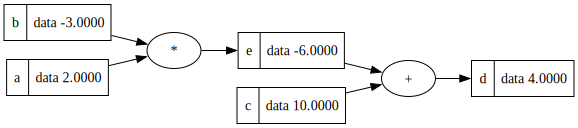

In [60]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f}" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

draw_dot(d)

We have a mathematical expression with inputs that produce a single output. Now we will create a final output.

In [65]:
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
draw_dot(L)

AttributeError: 'Value' object has no attribute 'grad'

Now we want to run backpropogation.

L is the loss function. The other variables are called the weights of the neural net. We will perform backpropogation by starting at L and determing the gradient at every node. So from the end go to the front

In [80]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0   # assume gradient is zero
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'{self.data=}'
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
d= a*b+c
d.label = 'd'

'+'

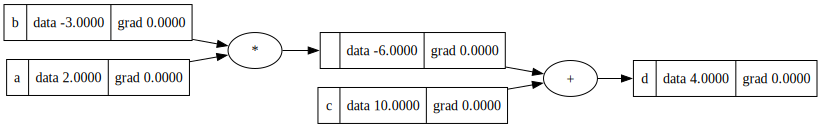

In [67]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

draw_dot(d)


Now we will fill in these gradients. For L, the derivative is 1. When you change L by x, L will change by x amount. So 1 to 1.

In [71]:
L.grad = 1.0


In [73]:
def test_gradient():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    # The derivative of L with respect to a
    # Because we are increasing a by 0.001, we are seeing how that change changes L
    print((L2 - L1)/h)
test_gradient()

6.000000000000227


Alternatively, we can change L with respect to H

In [75]:
def test_gradient():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h
    # The derivative of L with respect to a
    # Because we are increasing a by 0.001, we are seeing how that change changes L
    print((L2 - L1)/h)
test_gradient()


1.000000000000334


So it is 1.

In [78]:
L = d * f


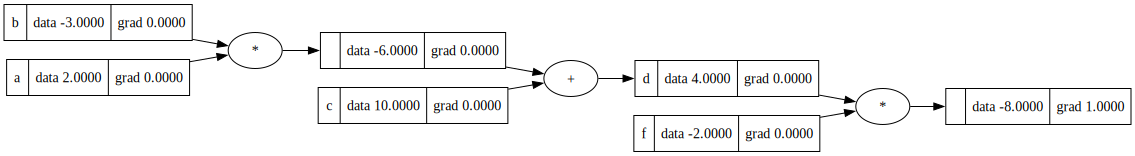

In [87]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0   # assume gradient is zero
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'{self.data=}'
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
d= a*b+c
d.label = 'd'
f = Value(-2.0, label='f')
L = f * d
L.grad = 1
draw_dot(L)

Let's continue with backpropogation

What is the derivative of L with respect to d and f?

For d: we would like to know what is dL/dd?
L = d * f, so dL/dd = f. Proof below

(f(x+h)-f(x))/h
Plug in x = d, to get the derivative with respect to d? You plug in x = d
(f(d+h)-f(d))/h
(f*d + f*h - f*d)/h
(f*h)/h
f

Therefore, the gradient of d is just the value of f.
By symmetry, the same would hold for dL/df = d

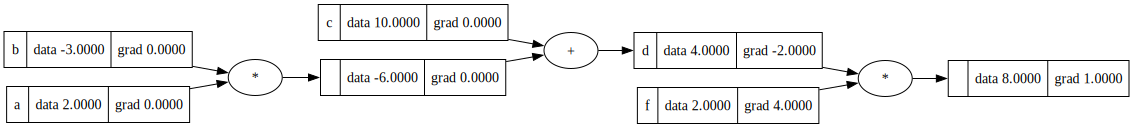

In [86]:
f.grad = 4.0
d.grad = -2.0
draw_dot(L)

Let's double check our work by running test_gradient

In [85]:
def test_gradient():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0 + h, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    # The derivative of L with respect to a
    # Because we are increasing a by 0.001, we are seeing how that change changes L
    print((L2 - L1)/h)
test_gradient()


3.9999999999995595


The gradient of L with respect to f is 4.0, so we are correct

Now we will derive dL/dc, the derive of L with respect to c.
We know how L is sensitive to d, but c is 2 steps away.
We know how c impacts d, and how d impacts L, so somehow c will impact L

First, we must know what is the derive of d with respect to c, dd/dc?

d = c + e

(f(x+h) - f(x))/h as h -> 0
(f(c+h) - f(c)/h)   # x = c
((c+h)+ e - (c+e))/h # f(x) = x + e, therefore f(c+h) = c + h + e
(c + h + e - c - e)/h
h/h
1.0

By symmetry, dd/de = 1.0. 

We call these two the local derivatives.


Next, we will the chain rule to calculate the derive of c with respect to L

If a variable z depends on variable y which depends on x, then z depends on x through intermediate variable y. In which case,

dz/dx = dz/dy * dy/dx

So basically, just multiply the derivatives together

dL/dc = dL/dd * dd/dc
dL/dc = -2.0 * 1

+ just distributes the derivative to all of the children notes

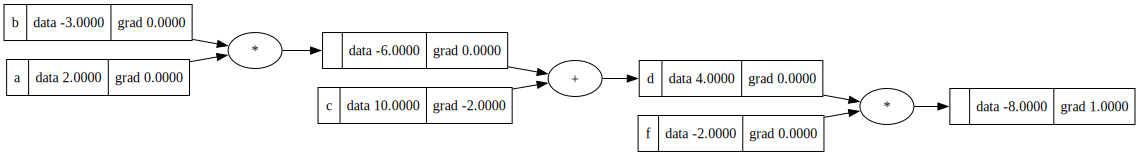

In [89]:
c.grad = -2.0
e.grad = -2.0
draw_dot(L)

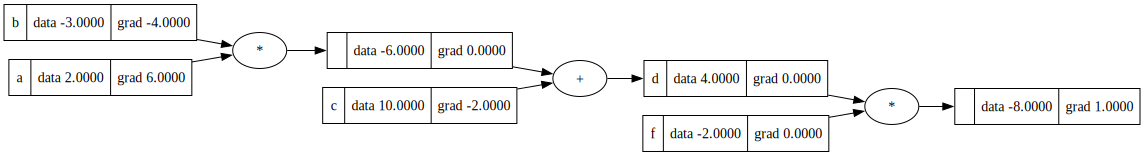

In [92]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2
draw_dot(L)

dL / de = -2.0

e = a  * b
de / da ? b
dL / da = (dL / de) * (de / da)

In [ ]:
a.data += a.grad 

In [93]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a+b
d = e+c
L = d + f
print(L.data)

7.0


Now, let's backpropogate through a neuron

What is a neuron?

There is an input, and there is a synapse which goes into the cell body

A cell body for a neuron has something called a squashing function, we can plot it similar to a tanh function

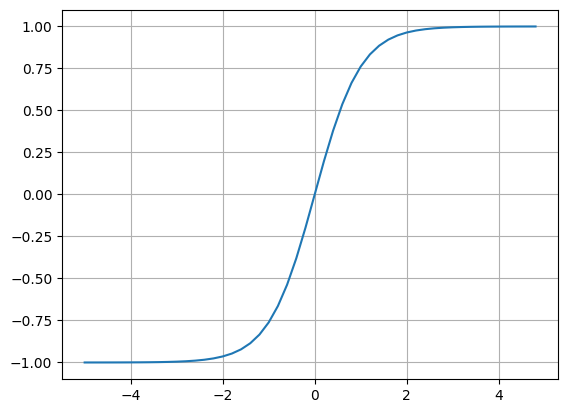

In [94]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

The inputs as they came in get squashed, at 0 they go positive, but as you get more positive, it will plateau.

We will cap it smoothly at one, at negative side cap it smoothly

Let's do an example. This is a neuron, with two inputs

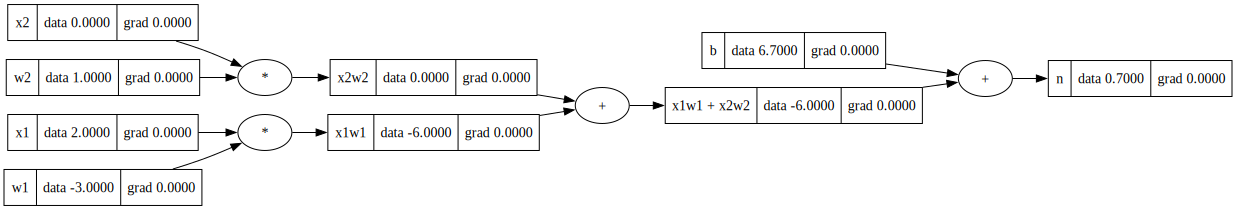

In [96]:
# inputs to the neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights of the neuron, the synaptics strength of each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
# the cell body, raw activation without activation function
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)


For the activation function, we need something like tanh which we haven't implemented yet in our Value function, so let's do that

We will cluster up the expression, and implement tanh

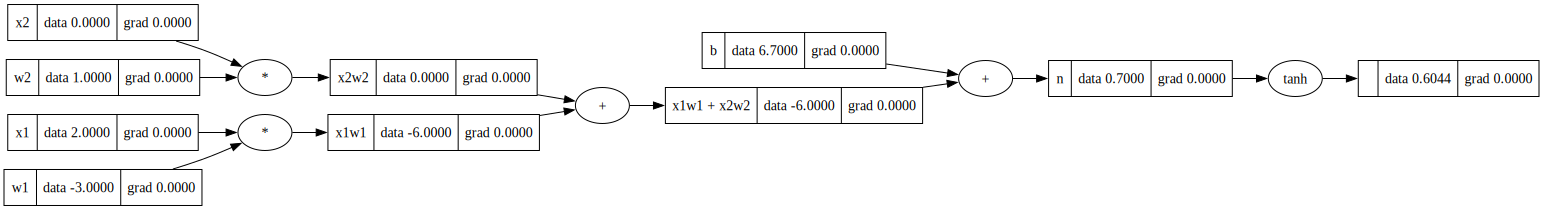

In [98]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0   # assume gradient is zero
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'{self.data=}'
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def tanh(self):
        n = self.data
        tanh = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
        out = Value(tanh, (self, ), 'tanh')
        return out

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
draw_dot(o)
